In [1]:
# Parameters
notebook_fname = "NN_full_RepeatedKFold_v3_BO_test"


In [2]:
import sys
sys.path.append("..")

In [3]:
# basic machine learning libaries
import os
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

# Data processing and plotting
import numpy as np
from numpy import asarray
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from tabulate import tabulate

# Bayesian Optimization
import GPyOpt

# Parellisation
from multiprocessing import Pool
from joblib import Parallel, delayed
import concurrent.futures

# Miscellaneous
from importlib import reload
import pickle
import time
# import warnings
# warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

print(f'cpu_count: {os.cpu_count()}')

# Data Path
data_path = '../Dataset_Cleaned/'
if os.path.isfile(data_path+'LiteratureDataset_Corrosion_YW_v3_processed.xlsx'):
    print(f"Folder '{data_path}' found.")

# Setting up multiple path for parallel Bayesian Optimization
num_str = notebook_fname.split("_")[-1]  # get the last string after "_"

try:
    bo_ens_num = int(num_str)
    print(f"bo_ens_num: {bo_ens_num}")
except ValueError:
    # if the string can't be converted to an integer, keep it as a string
    bo_ens_num = int(123)
    print(f"book master - bo_ens_num: {bo_ens_num}")

model_path = '../Model_Saved/'
model_path_bo = f'{model_path}{notebook_fname}/'

if not os.path.exists(model_path_bo):
    os.makedirs(model_path_bo)
    print(f"Folder '{model_path_bo}' created.")
else:
    print(f"Folder '{model_path_bo}' already exists.")

# Cleaning up previous tensorflow sessions
tf.keras.backend.clear_session()

# functionality control of the notebook
Flag_Training_try = True
Flag_BO_search = False
Flag_Training_BO_best = False

2023-07-12 12:51:19.583390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 12:51:22.487171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-07-12 12:51:22.487846: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-07-12 12:51:22.487874: W tens

cpu_count: 40
Folder '../Dataset_Cleaned/' found.
book master - bo_ens_num: 123
Folder '../Model_Saved/NN_full_RepeatedKFold_v3_BO_test/' already exists.


Use GPU or not


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print('not using GPU')


not using GPU


## Import hardness and corrosion dataset


In [5]:
# Declare column names for the chemical composition dataframe, specific testing conditions, selected features, and output for Hardness and Corrosion datasets.
compo_column = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si',
                'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
C_specific_testing_column = ['TestTemperature_C',
                             'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']
specific_features_sel_column = ['delta_a', 'Tm', 'sigma_Tm',
                                'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC']
H_output_column = ['converted HV']
C_output_column = ['AvgPittingPotential_mV']

# Load the Hardness and Corrosion datasets
df_H = pd.read_excel(
    data_path + 'LiteratureDataset_Hardness_YW_v3_processed.xlsx')
df_C = pd.read_excel(
    data_path + 'LiteratureDataset_Corrosion_YW_v3_processed.xlsx')

# Partition the datasets into component composition, specific features, and output data
df_H_compo, df_H_specific_features, df_H_output = df_H[compo_column], df_H[
    specific_features_sel_column], df_H[H_output_column]
(df_C_compo, df_C_specific_testing,
 df_C_specific_features, df_C_output) = df_C[compo_column], df_C[C_specific_testing_column], df_C[specific_features_sel_column], df_C[C_output_column]

df_H_compo_specific_features = pd.concat(
    [df_H_compo, df_H_specific_features], axis=1)
df_C_compo_specific_features = pd.concat(
    [df_C_compo, df_C_specific_features], axis=1)


## Data preprocessing

**hardness network**

- input (X1): df_H_compo
- input (Y1):
- input (V1): df_H_specific_features
- output(H1): df_H_output

**corrosion network**

- input (X2): df_C_compo
- input (Z2): df_C_specific_testing
- input (W2): df_C_specific_features
- output(C2): df_C_output

### obtain the MinMaxScaler from normalisation


In [6]:
# create an empty dataframe
df_H_specific_testing = pd.DataFrame()

# Prepare data for NN
dfs = [df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output,
       df_C_compo, df_C_specific_testing, df_C_specific_features, df_C_output]

# Convert DataFrames to numpy arrays
inputs_outputs = [np.asarray(df.values) for df in dfs]

# Define each variable
(X1, Y1, V1, H1,
 X2, Z2, W2, C2) = inputs_outputs

# Initialize MinMaxScalers for each data set
scalers = {
    "compo": MinMaxScaler(),
    "H_specific_testing": MinMaxScaler(),
    "C_specific_testing": MinMaxScaler(),
    "specific_features": MinMaxScaler(),
    "H_output": MinMaxScaler(),
    "C_output": MinMaxScaler()
}

# Fit scalers to appropriate data
scalers["compo"].fit(np.concatenate((X1, X2)))
if Y1.size != 0:  # if Y1 is empty
    scalers["H_specific_testing"].fit(Y1)
scalers["C_specific_testing"].fit(Z2)
scalers["specific_features"].fit(np.concatenate((V1, W2)))
scalers["H_output"].fit(H1.reshape((-1, 1)))
scalers["C_output"].fit(C2.reshape((-1, 1)))

print(scalers)

# Save the scalers dictionary to a file using pickle
with open(data_path + 'scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)


{'compo': MinMaxScaler(), 'H_specific_testing': MinMaxScaler(), 'C_specific_testing': MinMaxScaler(), 'specific_features': MinMaxScaler(), 'H_output': MinMaxScaler(), 'C_output': MinMaxScaler()}


### RepeatedKFold train-test split

- for hardness: `kfold_with_norm_H`

  - `X1_train_KFold`, `X1_test_KFold`,
  -
  - `V1_train_KFold`, `V1_test_KFold`,
  - `H1_train_KFold`, `H1_test_KFold` as lists used in model training

- for corrosion: `kfold_with_norm_C`
  - `X2_train_KFold`, `X2_test_KFold`,
  - `Z2_train_KFold`, `Z2_test_KFold`,
  - `W2_train_KFold`, `W2_test_KFold`,
  - `C2_train_KFold`, `C2_test_KFold` as lists used in model training


In [7]:
from utils.preprocessing_kfold_norm import kfold_with_norm_H, kfold_with_norm_C

n_splits, n_repeats, random_state = 6, 2, 42

# for hardness network
([X1_train_KFold, V1_train_KFold, H1_train_KFold],
 [X1_test_KFold, V1_test_KFold, H1_test_KFold],
 [X1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold],
 [X1_test_norm_KFold, V1_test_norm_KFold, H1_test_norm_KFold]) = kfold_with_norm_H(X1, V1, H1,
                                                                                   scalers["compo"], scalers["specific_features"], scalers["H_output"],
                                                                                   n_splits, n_repeats, random_state)

# for corrosion network
([X2_train_KFold, Z2_train_KFold, W2_train_KFold, C2_train_KFold],
 [X2_test_KFold, Z2_test_KFold, W2_test_KFold, C2_test_KFold],
 [X2_train_norm_KFold, Z2_train_norm_KFold,
     W2_train_norm_KFold, C2_train_norm_KFold],
 [X2_test_norm_KFold, Z2_test_norm_KFold, W2_test_norm_KFold, C2_test_norm_KFold]) = kfold_with_norm_C(X2, Z2, W2, C2,
                                                                                                       scalers["compo"], scalers["C_specific_testing"], scalers[
                                                                                                           "specific_features"], scalers["C_output"],
                                                                                                       n_splits, n_repeats, random_state)


### Plot the histogram of train/test data for each split

- Plotting hardness train/test datasets
- Plotting corrosion train/test datasets


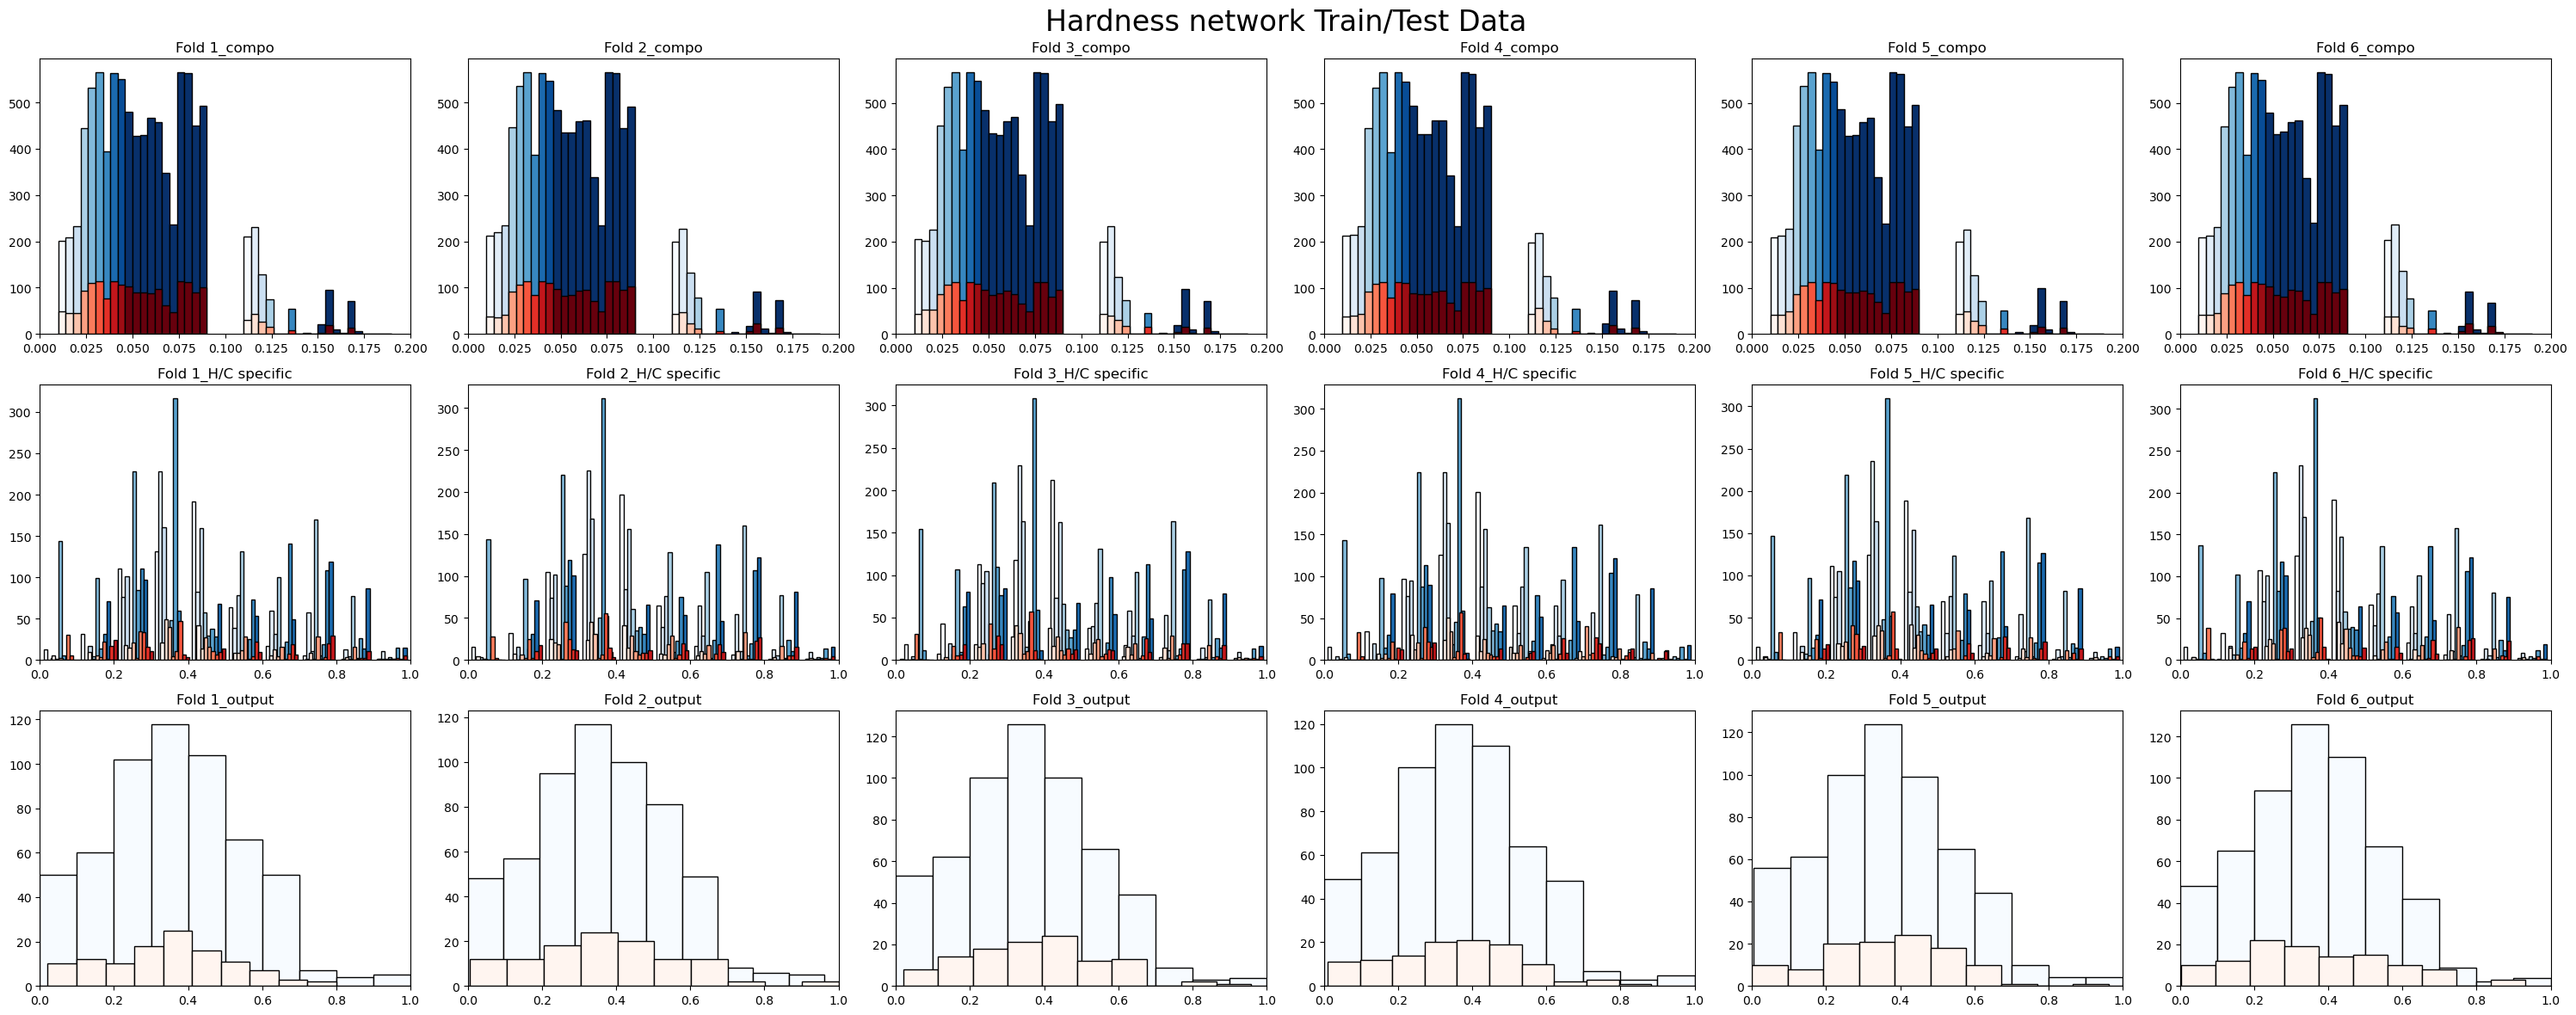

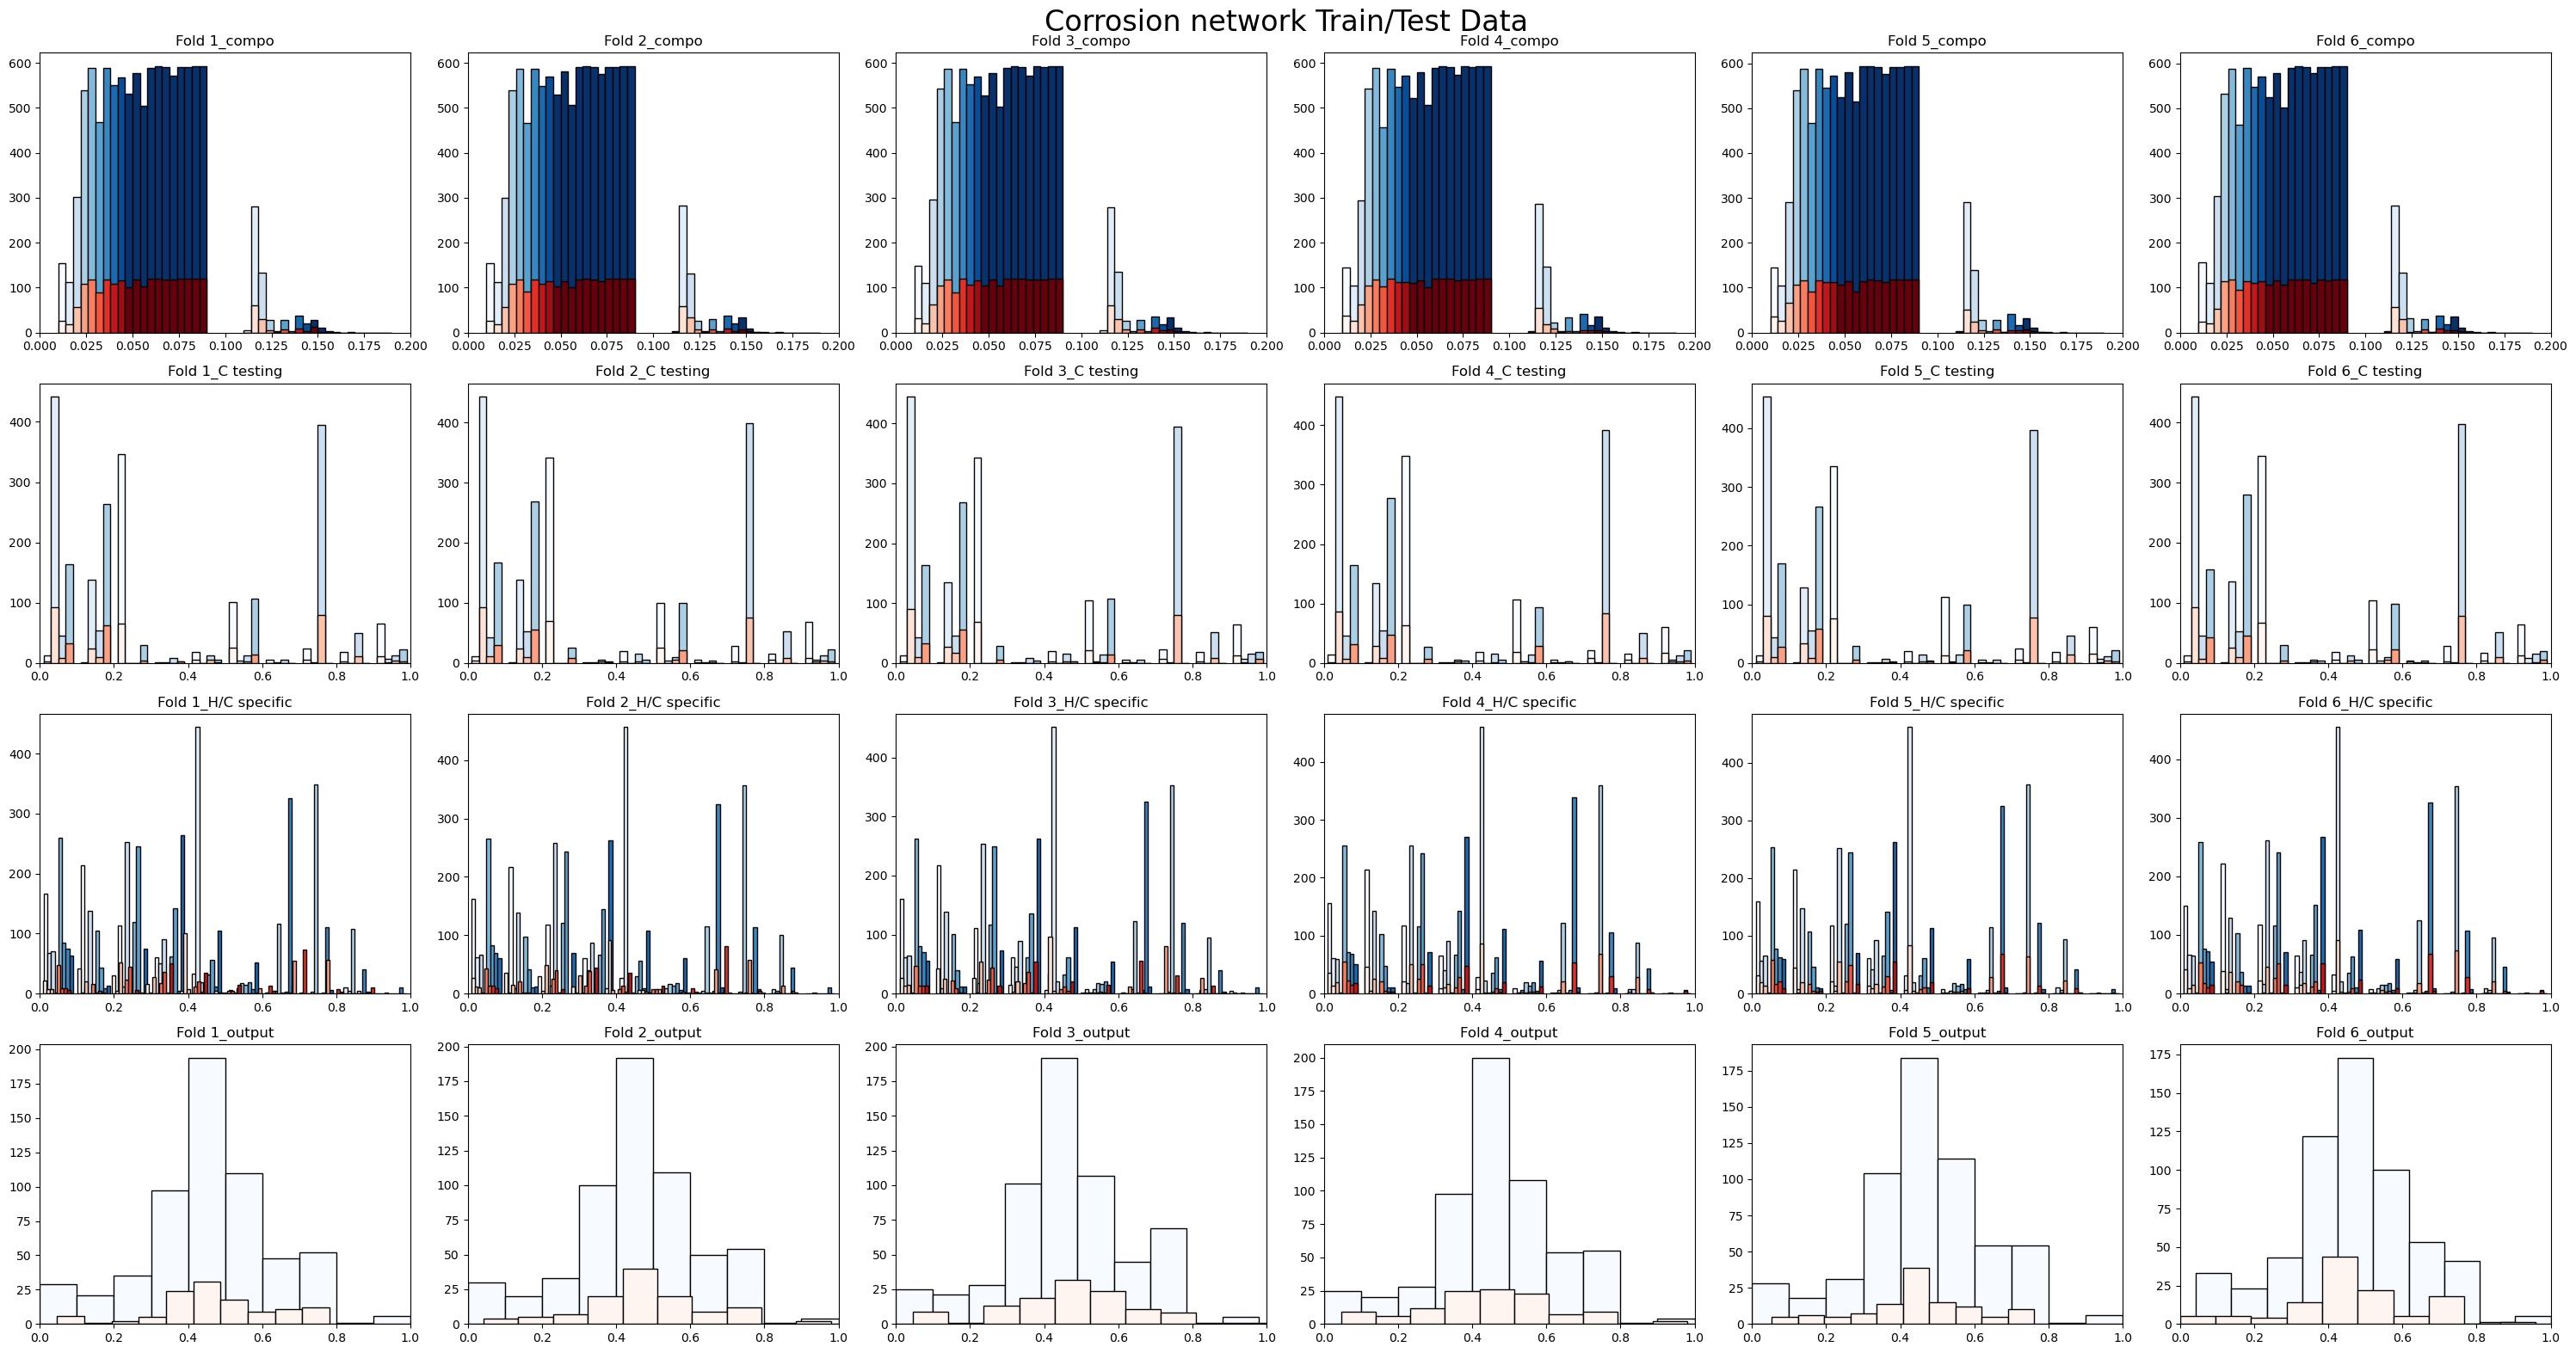

In [8]:
from utils.preprocessing_kfold_norm import plot_hist_kfold_with_norm

# call the function to plot the histograms - hardness network
plot_hist_kfold_with_norm(train_data=(X1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold),
                          test_data=(X1_test_norm_KFold,
                                     V1_test_norm_KFold,  H1_test_norm_KFold),
                          x_min=(0, 0, 0),
                          x_max=(0.2, 1, 1),
                          axs_title='Hardness network Train/Test Data',
                          n_splits=6, n_repeats=1, nrows=3, dataset='H')


# call the function to plot the histograms - corrosion network
plot_hist_kfold_with_norm(train_data=(X2_train_norm_KFold, Z2_train_norm_KFold, W2_train_norm_KFold, C2_train_norm_KFold),
                          test_data=(X2_test_norm_KFold,  Z2_test_norm_KFold,
                                     W2_test_norm_KFold, C2_test_norm_KFold),
                          x_min=(0, 0, 0, 0),
                          x_max=(0.2, 1, 1, 1),
                          axs_title='Corrosion network Train/Test Data',
                          n_splits=6, n_repeats=1, nrows=4, dataset='C')


## NN architecture, creation, evaluation:

- shared feature NN: NNF
- hardness NN: NNH
- corrosion NN: NNC

class: `MultiTaskNN`

```
       input2-->|
                |-->NNH-->output_H
                |
 input1-->NNF-->|
                |
                |-->NNC-->output_C
       input3-->|
```


### using `MultiTaskNN` class for training


In [9]:
if Flag_Training_try:

    from utils.multitask_nn import MultiTaskNN

    start_time = time.time()
    mt_nn = MultiTaskNN(NNF_num_nodes=64, NNF_num_layers=0,
                        NNH_num_nodes=64, NNH_num_layers=4,
                        NNC_num_nodes=64, NNC_num_layers=3,
                        mc_state=True, act='relu',
                        NNF_dropout=0.25, NNH_dropout=0.25, NNC_dropout=0.25,
                        loss_func=tf.keras.metrics.mean_squared_error,
                        learning_rate_H=0.001, learning_rate_C=0.001,
                        batch_size_H=32,
                        N_epochs_local=1, total_epochs=1000,
                        model_save_flag=True, model_path_bo=model_path_bo)

    # inputs for `RepeatedKFold`
    k_folds, n_CVrepeats = 6, 2

    # train_loss/val_loss: training/validation loss history
    # score_loss/score_r2: evaluated loss score/R2 score

    (train_loss_H, train_loss_C,
     val_loss_H,    val_loss_C,
     score_loss_H,  score_loss_C,
     score_r2_H,    score_r2_C) = mt_nn.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                               X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                               k_folds, n_CVrepeats)
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


Time taken:  528 seconds


### training quality for NNH_model and NNC_model


In [10]:
if Flag_Training_try:
    # training results by score_loss
    # print([f'{x:.4f}' for x in score_loss_H])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_H[i][-1]])
    print(
        f"score_loss_H: {np.mean(score_loss_H):.4f} ({np.std(score_loss_H):.4f})")

    # print([f'{x:.4f}' for x in score_loss_C])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_C[i][-1]])
    print(
        f"score_loss_C: {np.mean(score_loss_C):.4f} ({np.std(score_loss_C):.4f})")

    # training results by score_r2
    # print([f'{x:.4f}' for x in score_r2_H])
    print(
        f"score_r2_H:   {np.mean(score_r2_H):.4f} ({np.std(score_r2_H):.4f})")

    # print([f'{x:.4f}' for x in score_r2_C])
    print(f"score_r2_C: {np.mean(score_r2_C):.4f} ({np.std(score_r2_C):.4f})")

    print(f"score_r2_HC: {np.mean([score_r2_H, score_r2_C]):.4f}")


score_loss_H: 0.0124 (0.0022)
score_loss_C: 0.0081 (0.0015)
score_r2_H:   0.6859 (0.0488)
score_r2_C: 0.7717 (0.0515)
score_r2_HC: 0.7288


### plot the loss history


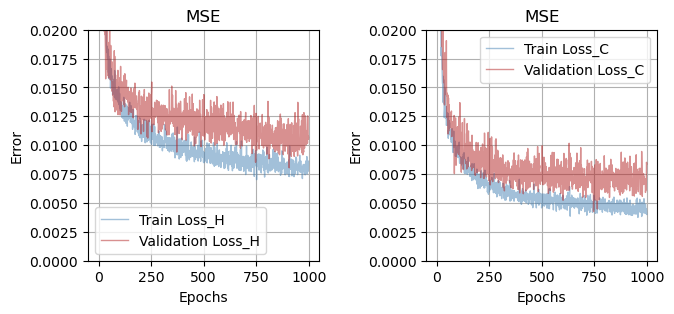

In [11]:
if Flag_Training_try:
    mt_nn.plot_losses(train_loss_H, val_loss_H, train_loss_C,
                      val_loss_C, k_folds=6, n_CVrepeats=2)


## Bayesian Hyperparameter Optimisation

class: `BO_hyper_objective`


### define the search domain


In [12]:
if Flag_BO_search:
    # Define the search space for hyperparameters
    search_space_NNF_NNH_NNC = [{'name': 'NNF_num_nodes',   'type': 'discrete',  'domain': (32, 64, 128, 256)},  # 0: NNF_num_nodes
                                {'name': 'NNF_num_layers',  'type': 'discrete',
                                    'domain': (1, 2, 3, 4, 5, 6)},  # 1: NNF_num_layers
                                {'name': 'NNH_num_nodes',   'type': 'discrete',
                                    'domain': (32, 64, 128, 256)},  # 2: NNH_num_nodes
                                {'name': 'NNH_num_layers',  'type': 'discrete',
                                    'domain': (1, 2, 3, 4, 5, 6)},  # 3: NNH_num_layers
                                {'name': 'NNC_num_nodes',   'type': 'discrete',
                                    'domain': (32, 64, 128, 256)},  # 4: NNC_num_nodes
                                {'name': 'NNC_num_layers',  'type': 'discrete',
                                    'domain': (1, 2, 3, 4, 5, 6)},  # 5: NNC_num_layers
                                {'name': 'NNF_dropout',     'type': 'continuous',
                                    'domain': (0.1, 0.5)},         # 6: NNF_dropout
                                {'name': 'NNH_NNC_dropout', 'type': 'continuous',
                                    'domain': (0.1, 0.5)},         # 7: NNH_NNC_dropout
                                {'name': 'loss_class',      'type': 'discrete',
                                    'domain': (0, 1)},             # 8: loss_class
                                {'name': 'learning_rate_H', 'type': 'continuous',
                                    'domain': (0.0001, 0.01)},     # 9: learning_rate_H
                                {'name': 'learning_rate_C', 'type': 'continuous',
                                    'domain': (0.0001, 0.01)},     # 10: learning_rate_C
                                {'name': 'batch_size_H',    'type': 'discrete',
                                    'domain': (16, 32, 64, 128)},  # 11: batch_size_H
                                {'name': 'N_epochs_local',  'type': 'discrete',  'domain': (1, 2, 3, 4)}]       # 12: N_epochs_global


### BO hyperparameter optimisation


In [13]:
if Flag_BO_search:
    from utils.BO_hyper_objective import BayesianOptimizationObjective

    start_time = time.time()

    # Set up the optimizer
    bo = None
    bo_iteration = 0

    score_r2_HC_list, score_loss_HC_list, score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list = [], [], [], [], [], []
    n_initial_points, n_iterations = 1, 1
    mc_state, act = True, 'relu'
    total_epochs = 50
    model_save_flag = False
    k_folds, n_CVrepeats = 6, 2
    np.random.seed(bo_ens_num)

    bo_obj = BayesianOptimizationObjective(bo_ens_num, model_path_bo)

    bo = GPyOpt.methods.BayesianOptimization(f=lambda x: bo_obj.BO_NNF_NNH_NNC_objective(x, n_initial_points, n_iterations,
                                                                                         mc_state, act,
                                                                                         total_epochs,
                                                                                         model_save_flag, model_path_bo,
                                                                                         X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                                         X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                                         k_folds, n_CVrepeats,
                                                                                         score_r2_HC_list, score_loss_HC_list,
                                                                                         score_r2_H_list, score_r2_C_list,
                                                                                         score_loss_H_list, score_loss_C_list)[0],  # Use only score_r2 as objective function
                                             domain=search_space_NNF_NNH_NNC,
                                             model_type='GP',
                                             initial_design_numdata=n_initial_points,
                                             init_design_type='random',
                                             acquisition_type='EI',
                                             acquisition_optimizer_type='lbfgs',
                                             acquisition_jitter=0,
                                             maximize=True)

    bo.run_optimization(max_iter=n_iterations)
    # Print the best hyperparameters and objective value found
    best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
    print("Best hyperparameters: {}".format(best_hyperparameters))
    print("Best objective value:", -bo.fx_opt)
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


### Save the BO hypertable


In [14]:
if Flag_BO_search:

    # update the hypertable
    bo_obj.update_hypertable(bo, score_r2_HC_list, score_loss_HC_list,
                             score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list)

    # Save the sorted data to an Excel file
    bo_obj.hypertable.to_excel(model_path_bo +
                               f"hypertable_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx", index=False)

    # sort the list start from the best results
    hypertable_sort = bo_obj.hypertable.sort_values(
        by=['score_r2_HC'], ascending=False, ignore_index=True)

    display(hypertable_sort.head())

    # Save the sorted data to an Excel file
    hypertable_sort.to_excel(model_path_bo +
                             f"hypertable_sort_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx", index=False)


### plotting the BO process


In [15]:
if Flag_BO_search:
    # plot the convergence
    bo.plot_convergence()

    bo_obj.plot_best_r2_score()


### Model training: using best BO hyperparameters


In [16]:
if Flag_Training_BO_best:

    start_time = time.time()

    # loading the best BO hyperparameters
    hypertable_sort = pd.read_excel(
        model_path_bo + f"hypertable_sort_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx")
    display(hypertable_sort.head(1))
    #
    # inputs for `RepeatedKFold`
    k_folds, n_CVrepeats = 6, 2

    loss_encoder = int(hypertable_sort.loc[0, 'loss_encoder'])
    if loss_encoder == 0:
        loss_func = tf.keras.metrics.mean_squared_error
    elif loss_encoder == 1:
        loss_func = tf.keras.metrics.mean_absolute_error
    else:
        raise ValueError(f"Invalid loss function '{loss_encoder}' ")

    mt_nn_BObest = MultiTaskNN(NNF_num_nodes=int(hypertable_sort.loc[0, 'NNF_num_nodes']), NNF_num_layers=int(hypertable_sort.loc[0, 'NNF_num_layers']),
                               NNH_num_nodes=int(hypertable_sort.loc[0, 'NNH_num_nodes']), NNH_num_layers=int(hypertable_sort.loc[0, 'NNH_num_layers']),
                               NNC_num_nodes=int(hypertable_sort.loc[0, 'NNC_num_nodes']), NNC_num_layers=int(hypertable_sort.loc[0, 'NNC_num_layers']),
                               mc_state=True, act='relu',
                               NNF_dropout=hypertable_sort.loc[0,
                                                               'NNF_dropout'],
                               NNH_dropout=hypertable_sort.loc[0,
                                                               'NNH_NNC_dropout'],
                               NNC_dropout=hypertable_sort.loc[0,
                                                               'NNH_NNC_dropout'],
                               loss_func=tf.keras.metrics.mean_squared_error,
                               learning_rate_H=hypertable_sort.loc[0,
                                                                   'learning_rate_H'],
                               learning_rate_C=hypertable_sort.loc[0,
                                                                   'learning_rate_C'],
                               batch_size_H=int(
        hypertable_sort.loc[0, 'batch_size_H']),
        N_epochs_local=int(hypertable_sort.loc[0, 'N_epochs_local']), total_epochs=50,
        model_save_flag=True, model_path_bo=model_path_bo)

    # evaluate model
    (train_loss_H, train_loss_C,
     val_loss_H,    val_loss_C,
     score_loss_H,  score_loss_C,
     score_r2_H,    score_r2_C) = mt_nn_BObest.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                      X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                      k_folds, n_CVrepeats)

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


In [17]:
if Flag_Training_BO_best:

    mt_nn_BObest.plot_losses(train_loss_H, val_loss_H, train_loss_C,
                             val_loss_C, k_folds=6, n_CVrepeats=2)


## Evaluate the training results

Show the model.h5 files in this directory


In [18]:
from utils.postprocessing_evalutation import display_saved_models

display_saved_models(model_path_bo)


NNH_model                      NNC_model
-----------------------------  -----------------------------
NNH_model_RepeatedKFold_1.h5   NNC_model_RepeatedKFold_1.h5
NNH_model_RepeatedKFold_2.h5   NNC_model_RepeatedKFold_2.h5
NNH_model_RepeatedKFold_3.h5   NNC_model_RepeatedKFold_3.h5
NNH_model_RepeatedKFold_4.h5   NNC_model_RepeatedKFold_4.h5
NNH_model_RepeatedKFold_5.h5   NNC_model_RepeatedKFold_5.h5
NNH_model_RepeatedKFold_6.h5   NNC_model_RepeatedKFold_6.h5
NNH_model_RepeatedKFold_7.h5   NNC_model_RepeatedKFold_7.h5
NNH_model_RepeatedKFold_8.h5   NNC_model_RepeatedKFold_8.h5
NNH_model_RepeatedKFold_9.h5   NNC_model_RepeatedKFold_9.h5
NNH_model_RepeatedKFold_10.h5  NNC_model_RepeatedKFold_10.h5
NNH_model_RepeatedKFold_11.h5  NNC_model_RepeatedKFold_11.h5
NNH_model_RepeatedKFold_12.h5  NNC_model_RepeatedKFold_12.h5


In [19]:
import pickle

# Save the scalers dictionary to a file using pickle
with open(data_path + 'scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

scalers


{'compo': MinMaxScaler(),
 'H_specific_testing': MinMaxScaler(),
 'C_specific_testing': MinMaxScaler(),
 'specific_features': MinMaxScaler(),
 'H_output': MinMaxScaler(),
 'C_output': MinMaxScaler()}

### plot true vs predictions (test data) for each RepeatedKFold


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

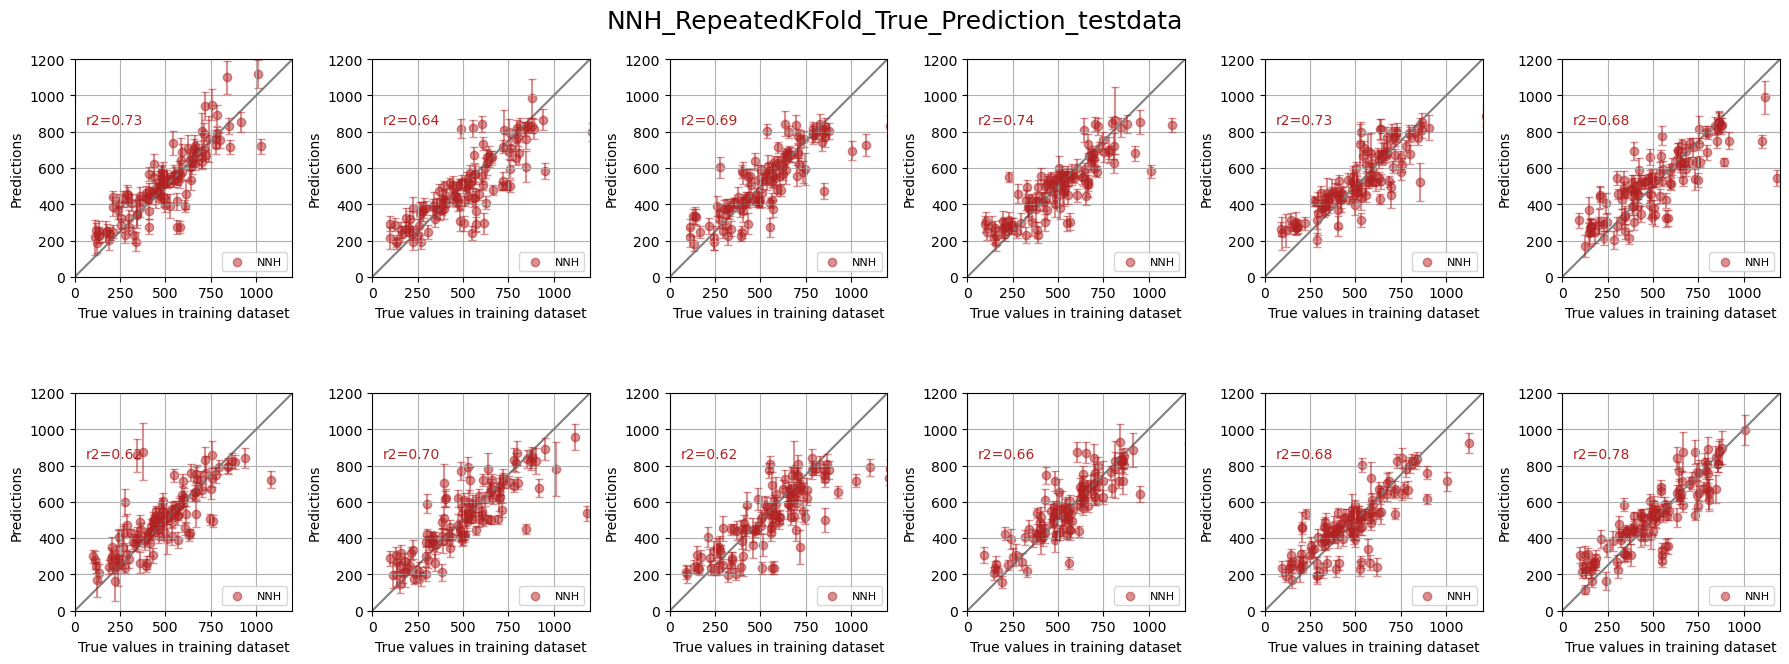

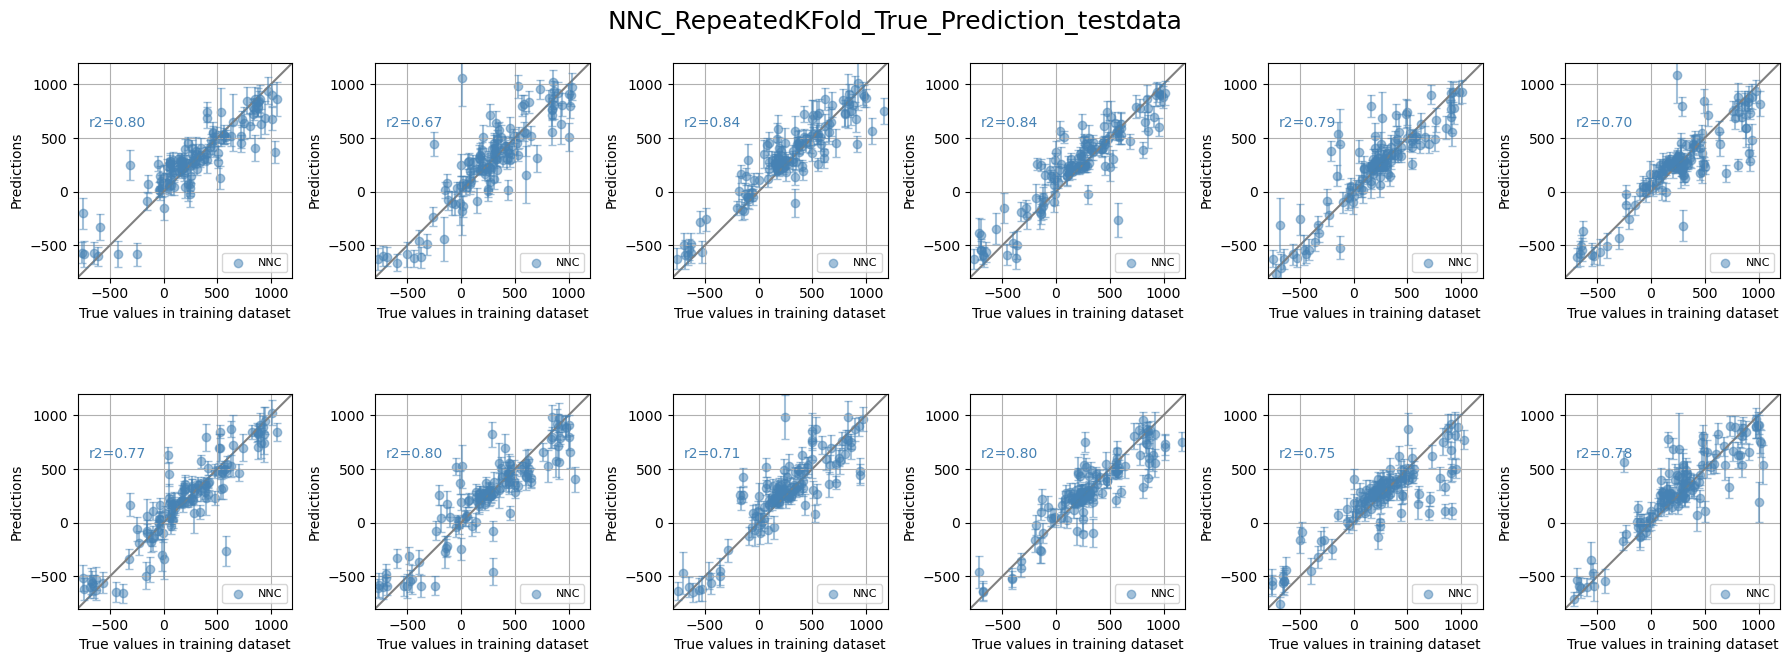

In [20]:
# # if Flag_Training_BO_best:

from utils.postprocessing_evalutation import predict_bootstrap, plot_test_true_vs_pred

NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_{}.h5', 'NNC_model_RepeatedKFold_{}.h5'
k_folds, n_CVrepeats, mc_repeat = 6, 2, 50

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                              X1_test_KFold, [], V1_test_KFold,
                              k_folds, n_CVrepeats, mc_repeat,
                              scalers["compo"], [], scalers["specific_features"], scalers["H_output"])

    future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                              X2_test_KFold, Z2_test_KFold, W2_test_KFold,
                              k_folds, n_CVrepeats, mc_repeat,
                              scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

H1_test_pred_X1_stack, H1_test_pred_X1_mean, H1_test_pred_X1_std = future1.result()
C2_test_pred_X2_stack, C2_test_pred_X2_mean, C2_test_pred_X2_std = future2.result()

plot_test_true_vs_pred(k_folds, n_CVrepeats, H1_test_KFold, H1_test_pred_X1_mean, H1_test_pred_X1_std,
                       [0, 1200], 'NNH', 'firebrick', model_path_bo)

plot_test_true_vs_pred(k_folds, n_CVrepeats, C2_test_KFold, C2_test_pred_X2_mean, C2_test_pred_X2_std,
                       [-800, 1200], 'NNC', 'steelblue', model_path_bo)


### plot true vs predictions (full dataset) including all model ensembles


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

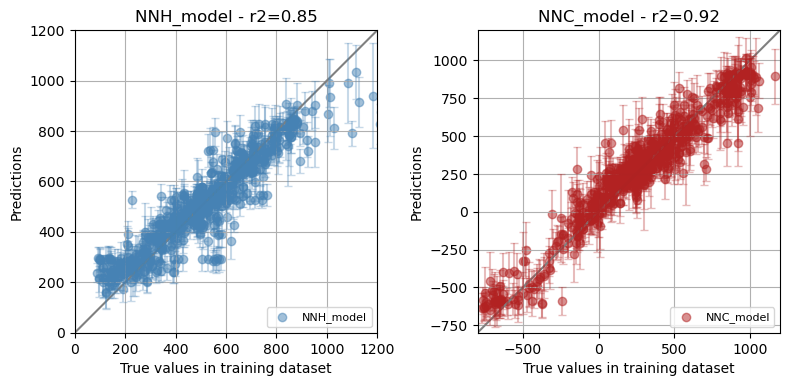

In [21]:
from utils.postprocessing_evalutation import predict_bootstrap, plot_full_true_vs_pred

X1_list, Y1_list, V1_list = [X1]*k_folds * \
    n_CVrepeats, [], [V1]*k_folds*n_CVrepeats
X2_list, Z2_list, W2_list = [
    X2]*k_folds*n_CVrepeats, [Z2]*k_folds*n_CVrepeats, [W2]*k_folds*n_CVrepeats

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                              X1_list, Y1_list, V1_list,
                              k_folds, n_CVrepeats, mc_repeat,
                              scalers["compo"], [], scalers["specific_features"], scalers["H_output"])

    future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                              X2_list, Z2_list, W2_list,
                              k_folds, n_CVrepeats, mc_repeat,
                              scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

H1_pred_X1_stack, H1_pred_X1_mean, H1_pred_X1_std = future1.result()
C2_pred_X2_stack, C2_pred_X2_mean, C2_pred_X2_std = future2.result()

plot_full_true_vs_pred([H1, C2], [H1_pred_X1_stack, C2_pred_X2_stack],
                       model_path_bo, lims=[[0, 1200], [-800, 1200]])
